# 5. Modeling & Answering the Questions Continued

In [1]:
# Imports
import sqlite3
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
#load in data
merged_data = pd.read_pickle("merged_data.pkl")
merged_data

,movie_id,primary_title,genres,individual_genre,runtime_minutes,title,studio,domestic_gross,foreign_gross,year,averagerating,numvotes,director_id,director_name,total_gross
0,tt0315642,Wazir,"Action,Crime,Drama",Action,103.0,Wazir,Relbig.,1100000.0,0.0,2016,7.1,15378,nm2349060,Bejoy Nambiar,1100000.0
1,tt0315642,Wazir,"Action,Crime,Drama",Crime,103.0,Wazir,Relbig.,1100000.0,0.0,2016,7.1,15378,nm2349060,Bejoy Nambiar,1100000.0
2,tt0315642,Wazir,"Action,Crime,Drama",Drama,103.0,Wazir,Relbig.,1100000.0,0.0,2016,7.1,15378,nm2349060,Bejoy Nambiar,1100000.0
3,tt0337692,On the Road,"Adventure,Drama,Romance",Adventure,124.0,On the Road,IFC,744000.0,8000000.0,2012,6.1,37886,nm0758574,Walter Salles,8744000.0
4,tt0337692,On the Road,"Adventure,Drama,Romance",Drama,124.0,On the Road,IFC,744000.0,8000000.0,2012,6.1,37886,nm0758574,Walter Salles,8744000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7764,tt9447594,The Gambler,"Action,Sci-Fi,Thriller",Thriller,121.0,The Gambler,Par.,33700000.0,5600000.0,2014,6.1,10,nm6981787,Tom Emmatty,39300000.0
7765,tt9816988,Gold,Drama,Drama,NaN,Gold,Wein.,7200000.0,7700000.0,2017,5.2,26,nm0787526,Parviz Shahbazi,14900000.0
7766,tt9851050,Sisters,"Action,Drama",Action,NaN,Sisters,Uni.,87000000.0,18000000.0,2015,4.7,14,nm1272773,Prachya Pinkaew,105000000.0
7767,tt9851050,Sisters,"Action,Drama",Drama,NaN,Sisters,Uni.,87000000.0,18000000.0,2015,4.7,14,nm1272773,Prachya Pinkaew,105000000.0


## 5.1 Franchise Power Analysis

Key Columns to focus on for this analysis:
- domestic_gross and foreign_gross for revenue.
- year for filtering data by 2018.
- genre for genre classification (for comparing genres within franchises).
- director for director consistency analysis.
- title for movie titles (identify franchises by titles).

Additional Considerations:
- Identify franchises by grouping related movies by title (e.g., "Avengers").
- Use total revenue to assess success.

In [3]:
# Filter the merged data for 2018
data_2018 = merged_data[merged_data['year'] == 2018]

# Calculate total revenue
data_2018['total_revenue'] = data_2018['domestic_gross'] + data_2018['foreign_gross']

# Group by title (to identify franchises) and calculate total revenue
franchise_revenue = data_2018.groupby('title')['total_revenue'].sum().reset_index()

# Sort by highest total revenue
franchise_revenue = franchise_revenue.sort_values(by='total_revenue', ascending=False).head(20)

# Display top 20 franchise films by revenue
print(franchise_revenue)


                                           title  total_revenue
17                        Avengers: Infinity War   4.072800e+09
29                                 Black Panther   4.041000e+09
92                Jurassic World: Fallen Kingdom   3.928500e+09
87                                 Incredibles 2   3.728400e+09
16                                       Aquaman   3.443400e+09
145                    Ralph Breaks the Internet   3.175200e+09
32                             Bohemian Rhapsody   2.710800e+09
122                Mission: Impossible - Fallout   2.373600e+09
46                                    Deadpool 2   2.337000e+09
197                                     The Mule   2.242500e+09
54   Fantastic Beasts: The Crimes of Grindelwald   1.961100e+09
14                          Ant-Man and the Wasp   1.867800e+09
146                             Ready Player One   1.748700e+09
137                            Operation Red Sea   1.737600e+09
49                         Detective Chi

/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_28475/1903353487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2018['total_revenue'] = data_2018['domestic_gross'] + data_2018['foreign_gross']


![Sheet 7.png](<attachment:Sheet 7.png>)
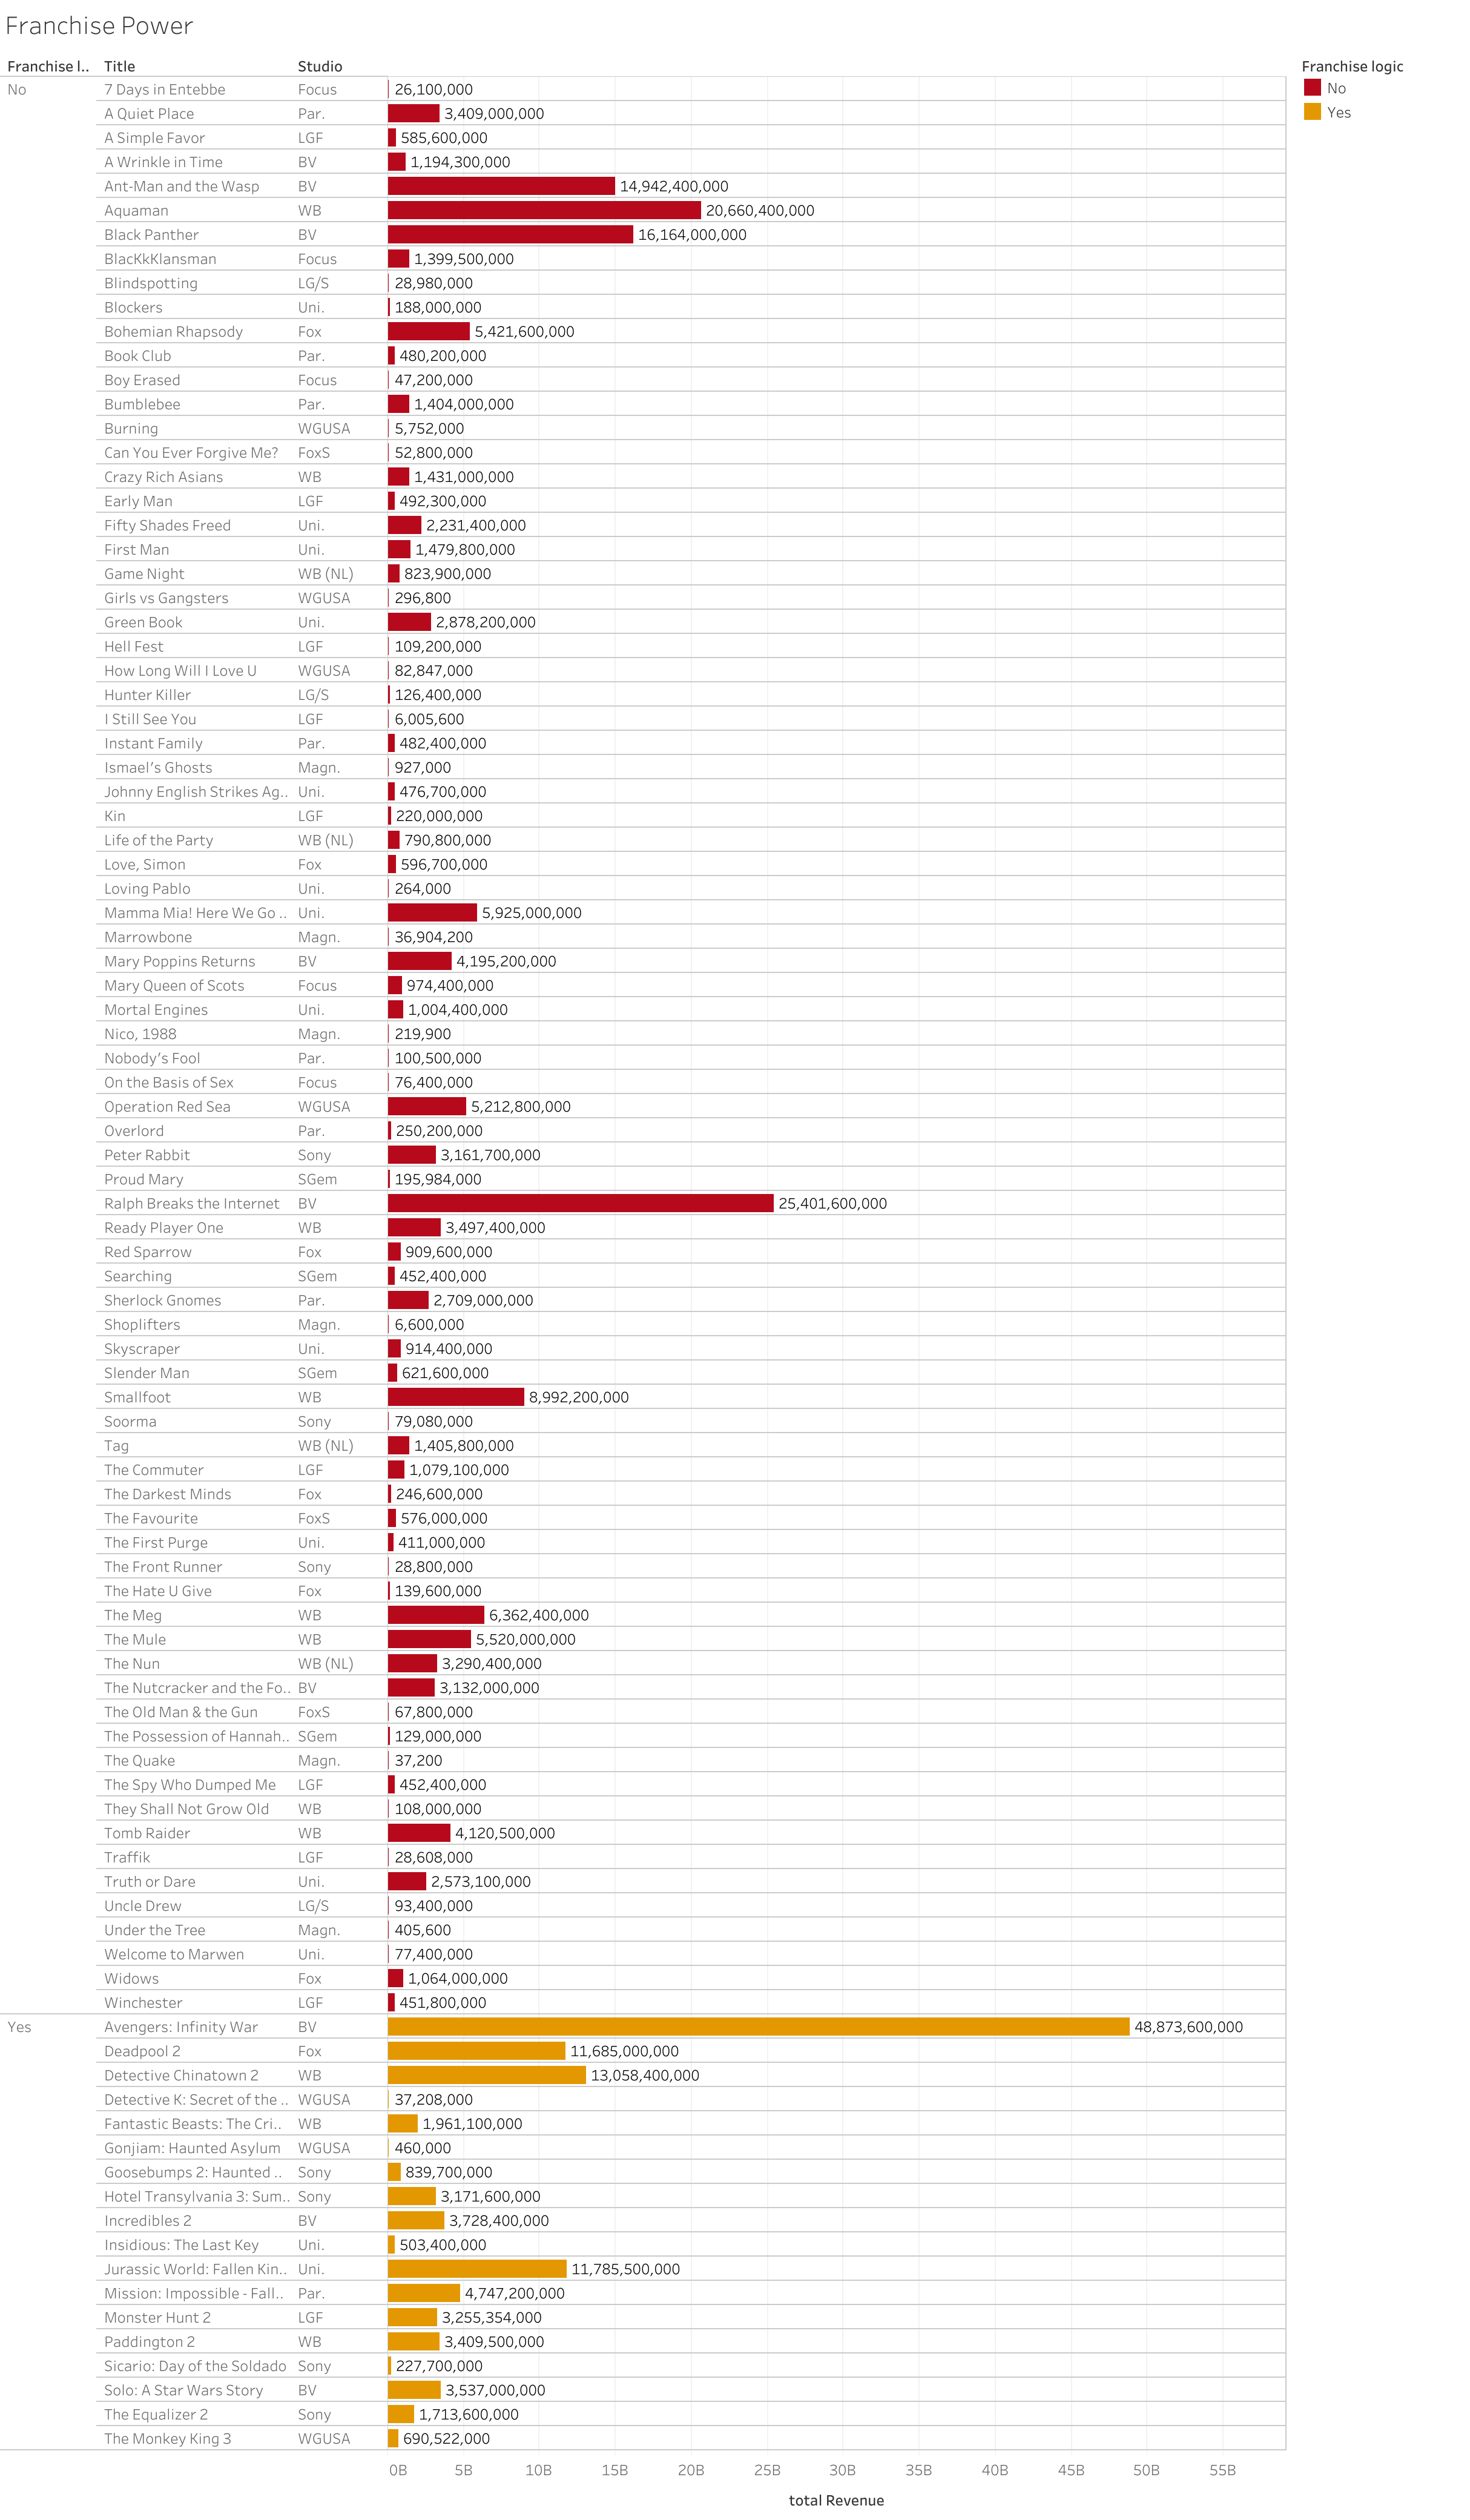

## 5.2 Director vs Studio Loyalty Analysis using a T-test

Hypothesis Testing:
- Null Hypothesis: There is no significant difference in total revenue between franchise movies directed by the same director and those directed by different directors.
- Alternative Hypothesis: Franchise movies directed by the same director generate higher revenue.

T-test will be used to compare the revenues of movies directed by the same director for a studio vs. those directed by different directors.

To group movies by director and analyze consistency within a studio:

In [5]:
# Filter data for 2018 and calculate total revenue
data_2018['total_revenue'] = data_2018['domestic_gross'] + data_2018['foreign_gross']

# Check director loyalty within a studio
director_loyalty = data_2018.groupby(['studio', 'director_name'])['total_revenue'].mean().reset_index()

# T-test: Compare revenue for movies directed by the same director vs. different directors
same_director = data_2018[data_2018.duplicated(subset=['studio', 'director_name'], keep=False)]
different_director = data_2018[~data_2018.duplicated(subset=['studio', 'director_name'], keep=False)]

# Perform T-test
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(same_director['total_revenue'], different_director['total_revenue'])

print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 2.631564458646235, P-value: 0.008681228104616459


/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_28475/2772400245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2018['total_revenue'] = data_2018['domestic_gross'] + data_2018['foreign_gross']


In [6]:
from scipy.stats import ttest_ind

# Separate data into two groups
franchise_directors = merged_data[merged_data['franchise'] == 'Yes']['domestic_gross'] + merged_data[merged_data['franchise'] == 'Yes']['foreign_gross']
non_franchise_directors = merged_data[merged_data['franchise'] == 'No']['domestic_gross'] + merged_data[merged_data['franchise'] == 'No']['foreign_gross']

# Perform the t-test
t_stat, p_value = ttest_ind(franchise_directors, non_franchise_directors)

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference in revenue.")
else:
    print("Fail to reject the null hypothesis. No significant difference in revenue.")


KeyError: 'franchise'

![Sheet 8.png](<attachment:Sheet 8.png>)
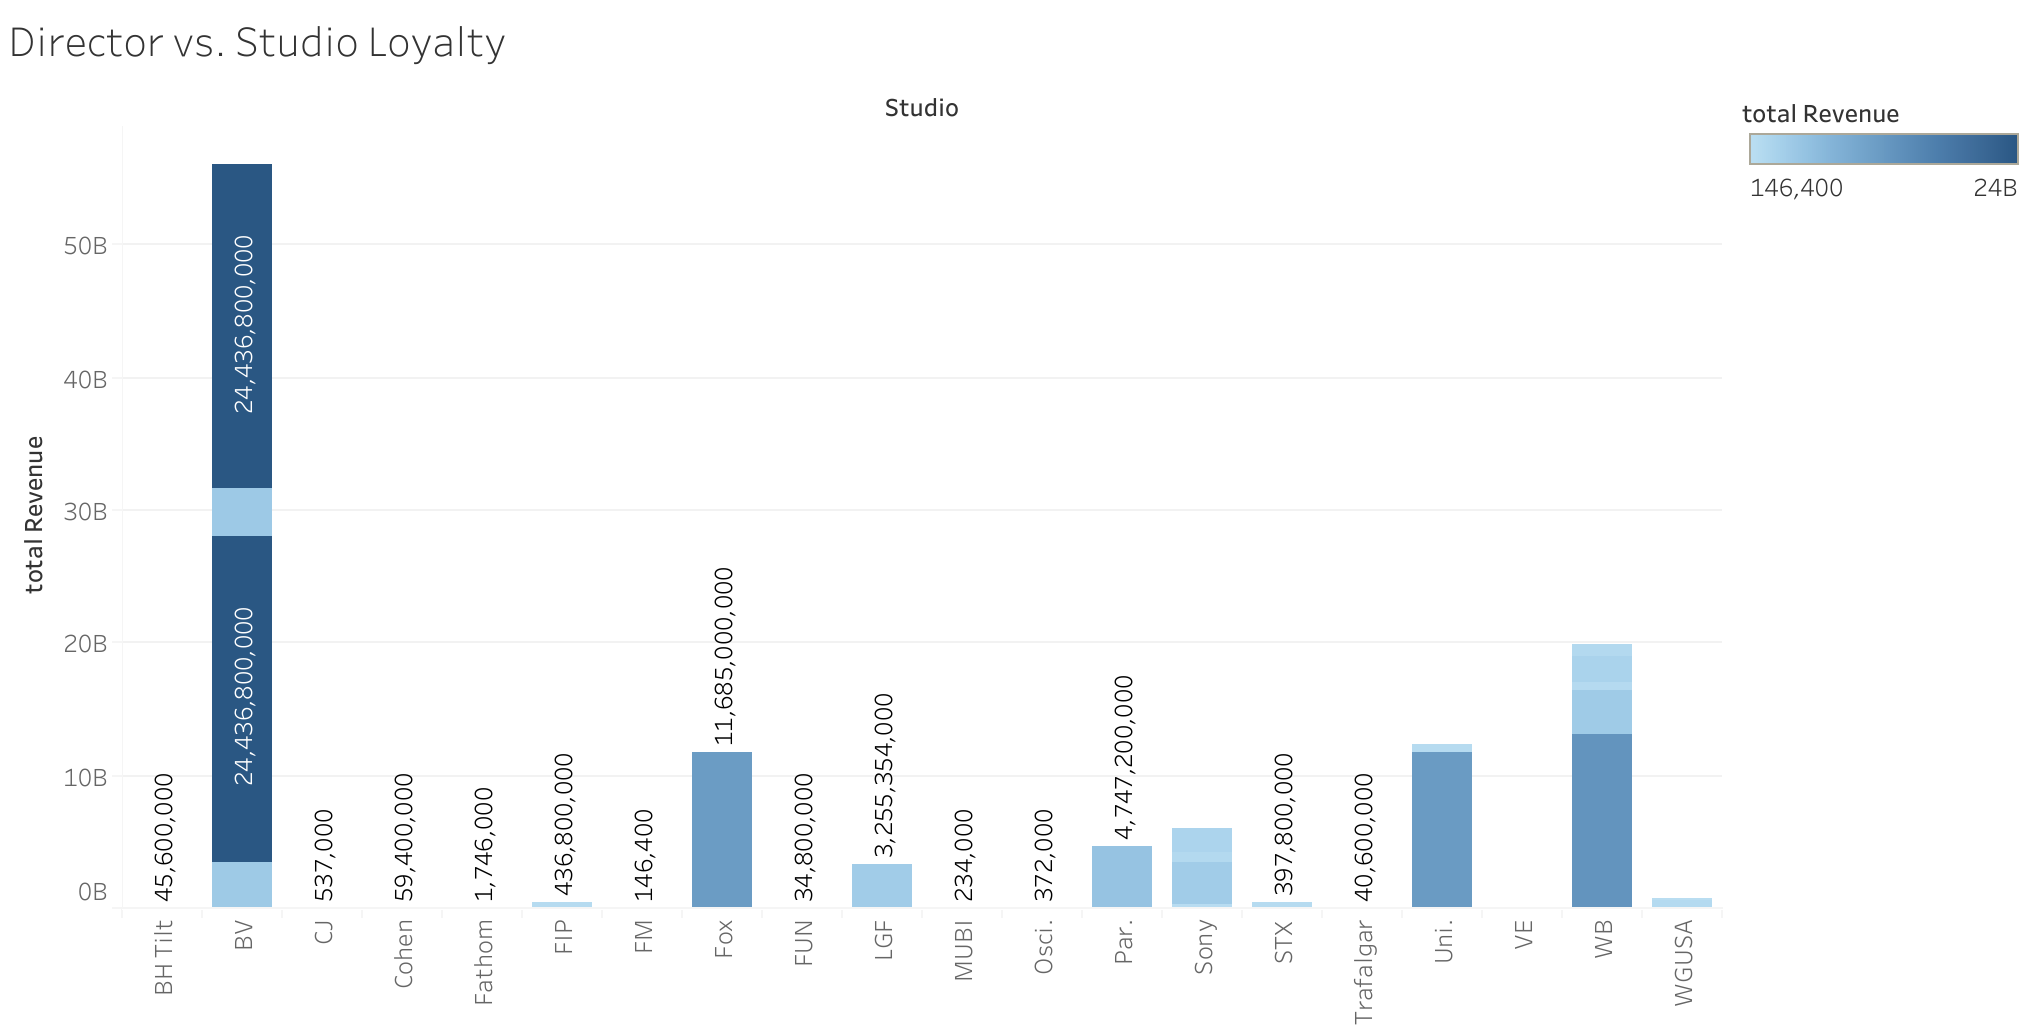